<a href="https://colab.research.google.com/github/Walt9819/factores-impacto-desempleo-mexico/blob/main/Machine_Learning/ML_restaurantes_2clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recuperación económica post-COVID: Localización óptima de restaurantes en México**


## **Instalación e importación de módulos**

In [1]:
!pip install geopandas
!pip install pandas_bokeh

     |████████████████████████████████| 1.0MB 4.4MB/s 
     |████████████████████████████████| 6.5MB 34.8MB/s 
     |████████████████████████████████| 15.3MB 195kB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import geopandas

import locale
from datetime import datetime
import plotly.express as px
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import dateutil

import pandas_bokeh
pandas_bokeh.output_notebook()
from tqdm import tqdm

## **Lectura de dataset**

In [3]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/Walt9819/factores-impacto-desempleo-mexico/main/Machine_Learning/data/data_merge_cluster.csv')
dataframe

,imun,ent,nom_ent,mun,nom_mun,pobtot,ing_lab,ocupados,desocupados,pob,pea,ocupada,tra_omun,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,CVEGEO,amenazas,danio_propiedad,extorsion,robo_negocio
0,1001,1,Aguascalientes,1,Aguascalientes,877190,7676.46,300564,24836,974529,382550,367528,9344,46426,23283,23142,334896,153478,181418,402,2092,192,506,1046,96,338,1001,3010,3370,88,1669
1,1002,1,Aguascalientes,2,Asientos,46464,5863.52,8138,693,51383,13914,13108,3585,989,549,440,5165,2023,3142,6,44,3,11,37,0,5,1002,96,116,1,45
2,1003,1,Aguascalientes,3,Calvillo,56048,5784.97,14757,199,61389,20099,19352,298,3280,1750,1529,14944,7370,7573,14,122,4,26,58,2,4,1003,60,139,3,54
3,1004,1,Aguascalientes,4,Cosío,15577,6096.05,3801,87,17076,4869,4627,1579,1000,591,408,4538,3172,1366,0,27,3,2,10,0,2,1004,17,35,4,22
4,1005,1,Aguascalientes,5,Jesús María,120405,6262.18,37341,3187,132340,51020,49795,19699,6377,3402,2975,63320,22688,40631,28,207,24,57,154,3,28,1005,270,404,7,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,32054,32,Zacatecas,54,Villa Hidalgo,19155,1877.31,7685,0,20278,4538,4324,387,423,235,188,1176,690,486,0,17,2,9,10,0,0,32054,1,5,3,0
2459,32055,32,Zacatecas,55,Villanueva,30240,0.00,0,0,31980,9018,8176,933,3532,2063,1468,8319,4943,3376,10,69,9,22,48,2,3,32055,35,57,7,3
2460,32056,32,Zacatecas,56,Zacatecas,146147,7421.03,48024,3552,156434,60889,58330,4770,9716,5047,4669,82912,41650,41262,134,305,41,101,222,32,44,32056,297,512,98,62
2461,32057,32,Zacatecas,57,Trancoso,19413,6537.04,7025,281,20440,6039,5703,2474,665,408,257,1928,1011,917,3,30,1,11,10,0,0,32057,33,25,11,2


In [7]:
df = dataframe.drop(['imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO','pob','tra_omun','ocupados','desocupados'], axis=1)

In [8]:
df

,pobtot,ing_lab,pea,ocupada,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,amenazas,danio_propiedad,extorsion,robo_negocio
0,877190,7676.46,382550,367528,46426,23283,23142,334896,153478,181418,402,2092,192,506,1046,96,338,3010,3370,88,1669
1,46464,5863.52,13914,13108,989,549,440,5165,2023,3142,6,44,3,11,37,0,5,96,116,1,45
2,56048,5784.97,20099,19352,3280,1750,1529,14944,7370,7573,14,122,4,26,58,2,4,60,139,3,54
3,15577,6096.05,4869,4627,1000,591,408,4538,3172,1366,0,27,3,2,10,0,2,17,35,4,22
4,120405,6262.18,51020,49795,6377,3402,2975,63320,22688,40631,28,207,24,57,154,3,28,270,404,7,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,19155,1877.31,4538,4324,423,235,188,1176,690,486,0,17,2,9,10,0,0,1,5,3,0
2459,30240,0.00,9018,8176,3532,2063,1468,8319,4943,3376,10,69,9,22,48,2,3,35,57,7,3
2460,146147,7421.03,60889,58330,9716,5047,4669,82912,41650,41262,134,305,41,101,222,32,44,297,512,98,62
2461,19413,6537.04,6039,5703,665,408,257,1928,1011,917,3,30,1,11,10,0,0,33,25,11,2


## **Análisis exploratorio**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pobtot                2463 non-null   int64  
 1   ing_lab               2463 non-null   float64
 2   pea                   2463 non-null   int64  
 3   ocupada               2463 non-null   int64  
 4   tot_est               2463 non-null   int64  
 5   est_e_a               2463 non-null   int64  
 6   est_n_e_a             2463 non-null   int64  
 7   tot_p_o               2463 non-null   int64  
 8   po_e_a                2463 non-null   int64  
 9   po_n_e_a              2463 non-null   int64  
 10  comida_carta_corrida  2463 non-null   int64  
 11  antojitos             2463 non-null   int64  
 12  pescados_mariscos     2463 non-null   int64  
 13  comida_rapida         2463 non-null   int64  
 14  tacos_tortas          2463 non-null   int64  
 15  autoservicio         

In [10]:
df.describe()

,pobtot,ing_lab,pea,ocupada,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,amenazas,danio_propiedad,extorsion,robo_negocio
count,2.463000e+03,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000
mean,4.853055e+04,2025.390784,19079.366626,18305.079172,2545.380024,1372.764921,1172.619570,14390.391799,6976.963053,7413.426309,26.553390,56.247665,9.911084,27.670321,54.974421,4.040195,25.425903,53.805522,60.557450,4.036947,47.349574
std,1.389110e+05,3036.525818,60993.926541,58576.515795,6835.736585,3589.315522,3288.888333,55649.212540,26726.803631,29649.960914,103.105868,170.917568,35.499806,83.428942,177.986835,19.159841,96.335506,227.603907,248.953623,19.086017,267.588507
min,0.000000e+00,0.000000,0.000000,0.000000,7.000000,5.000000,2.000000,17.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.230500e+03,0.000000,1206.500000,1170.000000,168.000000,95.000000,64.500000,498.000000,271.000000,195.500000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.326100e+04,0.000000,4137.000000,3906.000000,616.000000,345.000000,260.000000,1886.000000,1030.000000,788.000000,3.000000,10.000000,1.000000,6.000000,10.000000,0.000000,4.000000,4.000000,5.000000,0.000000,0.000000
75%,3.432900e+04,4363.840000,11050.500000,10665.500000,2020.500000,1117.500000,915.500000,6759.000000,3481.000000,3156.500000,13.000000,38.000000,5.000000,18.000000,33.000000,1.000000,13.000000,18.000000,24.000000,1.000000,5.000000
max,1.827868e+06,36323.240000,825520.000000,786218.000000,95568.000000,50880.000000,50039.000000,879056.000000,505363.000000,401413.000000,2018.000000,2552.000000,570.000000,1147.000000,3030.000000,280.000000,1619.000000,3366.000000,4835.000000,403.000000,4664.000000


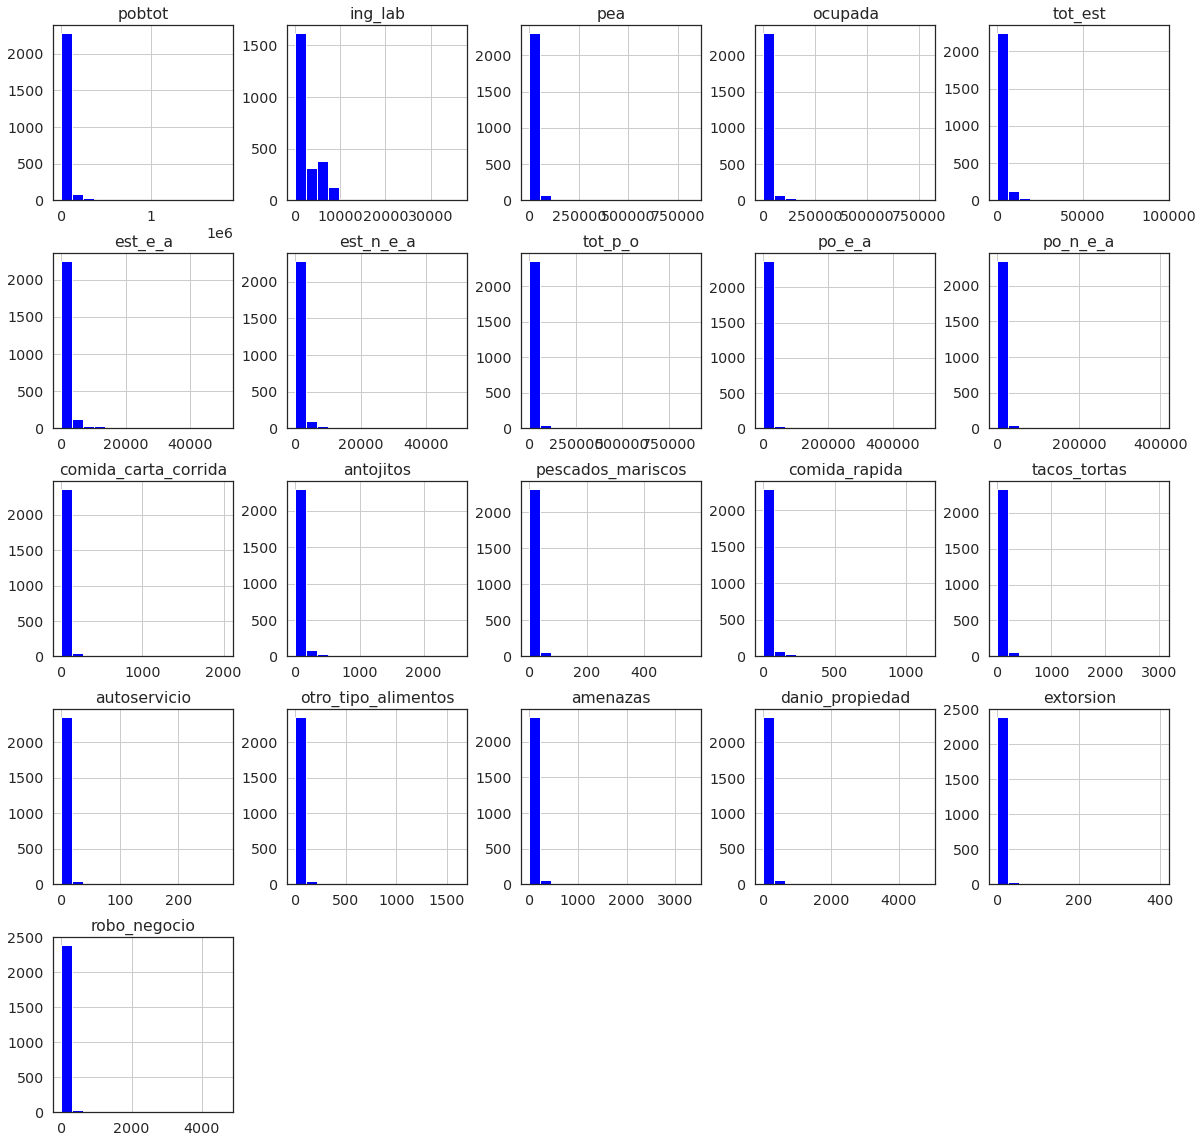

In [12]:
ax = df.hist(bins=15,color='blue')

## **Normalización de datos**

Para ayudar a nuestro algoritmo K-Means en la interpretación de características con diferentes magnitudes y distribuciones, se normalizaron los datos y  se aplicó PCA (Principal Component Analysis) para reducir dimensiones del espacio de características original, debido a que nos cuestionamos ¿cuáles atributos deberíamos elegir para obtener buenas predicciones o agrupamientos, sin perder información valiosa?  

In [13]:
scaler = StandardScaler()

scaler.fit(df) # Calcula la media y estandar para cada dimensión
X_scaled=scaler.transform(df) # Transforma los datos a su nueva escala

In [14]:
X_scaled

array([[ 5.96660941e+00,  1.86140909e+00,  5.96033839e+00, ...,
         1.32961093e+01,  4.40008528e+00,  6.06147007e+00],
       [-1.48798363e-02,  1.26424369e+00, -8.47037702e-02, ...,
         2.22747545e-01, -1.59151251e-01, -8.78233087e-03],
       [ 5.41279869e-02,  1.23837006e+00,  1.67203603e-02, ...,
         3.15152990e-01, -5.43412160e-02,  2.48582305e-02],
       ...,
       [ 7.02869208e-01,  1.77727285e+00,  6.85611271e-01, ...,
         1.81372826e+00,  4.92413546e+00,  5.47609517e-02],
       [-2.09655569e-01,  1.48609485e+00, -2.13841204e-01, ...,
        -1.42856611e-01,  3.64898925e-01, -1.69509457e-01],
       [-3.30311255e-01, -6.67144689e-01, -3.01228300e-01, ...,
        -2.27226800e-01, -2.11556269e-01, -1.76985138e-01]])

## **Busquéda de los componentes principales con algoritmo PCA**

In [15]:
pca = PCA(n_components=5)
#pca=PCA(.85)
pca.fit(X_scaled) # Buscar los componentes principales
X_pca=pca.transform(X_scaled) 
#Se revisa la forma del array
print("shape of X_pca", X_pca.shape)

shape of X_pca (2463, 5)


De tal manera que elegir arbitrariamente las dimensiones a considerar dentro del algoritmo no supervisado, no era la opción, así que optamos por calcular la proporción de variación explicada con la cual alcanzamos a explicar 94.07% de la variabilidad total con 5 componentes. 

## Varianza explicada

Varianza explicada del **94%**con los componentes principales calculados en el segmento de código anterior.

In [16]:
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))
# Con 5 componentes tenemos algo mas del 97% de varianza explicada

[0.81386917 0.04308975 0.039193   0.02389431 0.02068521]
suma: 0.9407314436327181


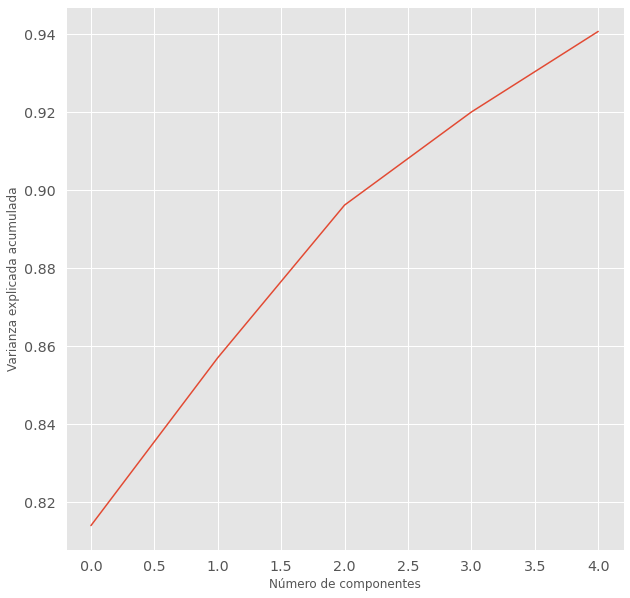

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.show()

No handles with labels found to put in legend.


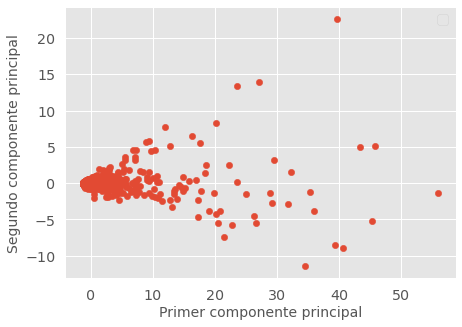

In [18]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

ax.scatter(Xax,Yax,s=40)

plt.xlabel("Primer componente principal",fontsize=14)
plt.ylabel("Segundo componente principal",fontsize=14)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



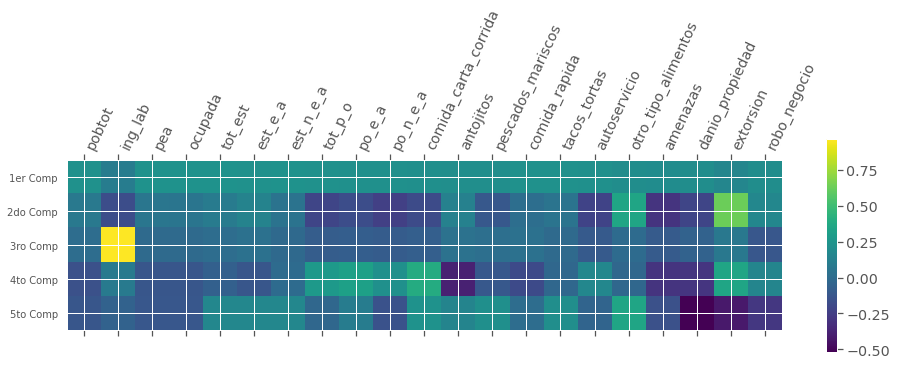

In [20]:
plt.matshow(pca.components_[0:5],cmap='viridis')
plt.yticks([0,1,2,3,4],['1er Comp','2do Comp','3ro Comp','4to Comp','5to Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df.columns)),df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()# 

In [21]:
components = pd.DataFrame(pca.components_, columns = df.columns)
components.shape

(5, 21)

## Algoritmo K-Means

Después de deshacernos de los autovectores de menor importancia relativa, se identificó el número óptimo de grupos a definir en nuestro algoritmo K-means. Se utilizó la distancia media al centroide en función de k y se encontró el punto codo donde la tasa de descenso se quiebra o se afila.

In [22]:
import sklearn.cluster as cluster

inertia = []
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

100%|██████████| 8/8 [00:01<00:00,  4.78it/s]


In [23]:
from sklearn.metrics import silhouette_score

silhouette = {}
for i in tqdm(range(2,10)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(X_scaled)
    silhouette[i] = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')

100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


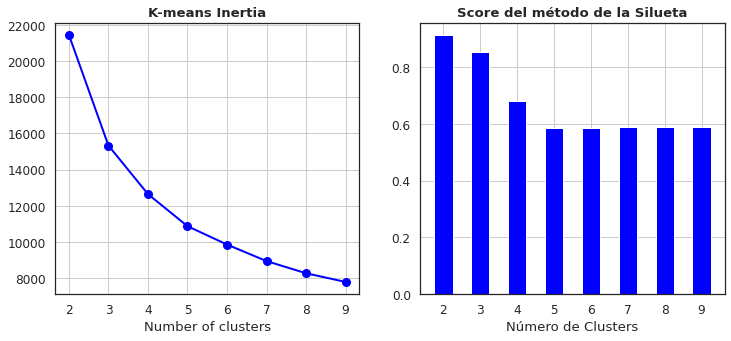

In [54]:
plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='o',lw=2,ms=8,color='blue')
plt.xlabel('Number of clusters')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue',width=0.5)
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid()
plt.title('Score del método de la Silueta',fontweight='bold')
plt.xlabel('Número de Clusters')

plt.show()

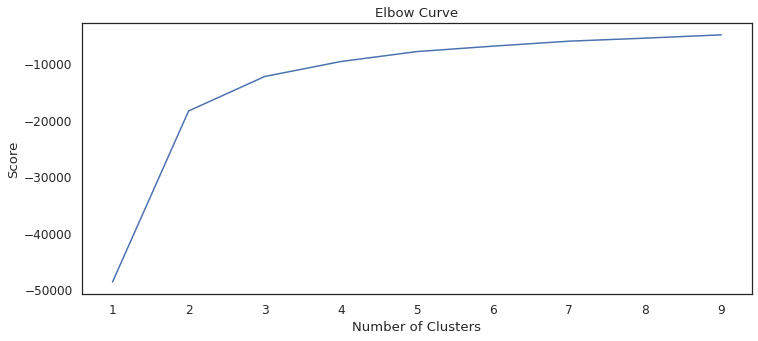

In [25]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X_pca).score(X_pca) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

A nuestro criterio y con la gráfica de la curva de codo, se consideró que 2 era buen número para el valor K. Ejecutamos el algoritmo para 2 clusters, y graficamos con colores los grupos para ver si se lograban diferenciar entre ellos presentando una buena separación y compactación.  

In [26]:
# Para el proyecto, se eligio el valor 2 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=2).fit(X_pca)
centroids = kmeans.cluster_centers_
print(centroids)

[[-5.14559583e-01  2.74396940e-03  1.60308666e-02 -3.12530541e-03
   5.04611359e-03]
 [ 2.38577530e+01 -1.27225197e-01 -7.43277294e-01  1.44905987e-01
  -2.33964997e-01]]


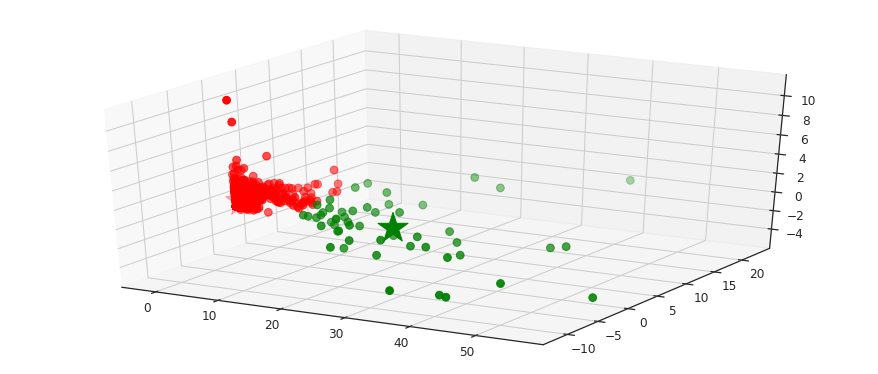

In [27]:
# Se obtienen las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X_pca)
# Se obtienen los centroids
C = kmeans.cluster_centers_
colores=['red','green']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [35]:
# Se cuentan los usuarios que hay en cada grupo
copy =  pd.DataFrame()
copy['imun']=dataframe['imun'].values
copy['ent']=dataframe['ent'].values
copy['nom_ent']=dataframe['nom_ent'].values
copy['mun']=dataframe['mun'].values
copy['nom_mun']=dataframe['nom_mun'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,2411
1,green,52


In [37]:
copy.head()

,imun,ent,nom_ent,mun,nom_mun,label
0,1001,1,Aguascalientes,1,Aguascalientes,1
1,1002,1,Aguascalientes,2,Asientos,0
2,1003,1,Aguascalientes,3,Calvillo,0
3,1004,1,Aguascalientes,4,Cosío,0
4,1005,1,Aguascalientes,5,Jesús María,0


In [39]:
column_values = ['C1','C2','C3','C4','C5']  
df_pca = pd.DataFrame(data = X_pca,    
                  columns = column_values) 

In [40]:
df_pca['CVEGEO']=dataframe['CVEGEO'].values
df_pca['imun']=dataframe['imun'].values
df_pca['ent']=dataframe['ent'].values
df_pca['nom_ent']=dataframe['nom_ent'].values
df_pca['mun']=dataframe['mun'].values
df_pca['nom_mun']=dataframe['nom_mun'].values
df_pca['label'] = labels;
df_pca['pobtot']=dataframe['pobtot'].values
df_pca['ing_lab']=dataframe['ing_lab'].values
df_pca['pea']=dataframe['pea'].values
df_pca['ocupada']=dataframe['ocupada'].values
df_pca['tot_est']=dataframe['tot_est'].values
df_pca

,C1,C2,C3,C4,C5,CVEGEO,imun,ent,nom_ent,mun,nom_mun,label,pobtot,ing_lab,pea,ocupada,tot_est
0,29.129027,-2.706719,-1.546377,-7.802444,-5.706800,1001,1001,1,Aguascalientes,1,Aguascalientes,1,877190,7676.46,382550,367528,46426
1,-0.387030,-0.383548,1.231530,-0.152269,-0.421775,1002,1002,1,Aguascalientes,2,Asientos,0,46464,5863.52,13914,13108,989
2,0.254651,-0.242492,1.200353,-0.207465,-0.251577,1003,1003,1,Aguascalientes,3,Calvillo,0,56048,5784.97,20099,19352,3280
3,-0.738144,-0.190597,1.375053,0.193453,-0.244863,1004,1004,1,Aguascalientes,4,Cosío,0,15577,6096.05,4869,4627,1000
4,2.636880,-0.741091,0.990886,-0.463559,-0.842080,1005,1005,1,Aguascalientes,5,Jesús María,0,120405,6262.18,51020,49795,6377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,-1.054278,0.041267,0.064727,0.060375,-0.122994,32054,32054,32,Zacatecas,54,Villa Hidalgo,0,19155,1877.31,4538,4324,423
2459,-0.306748,0.271599,-0.547486,-0.151588,0.059271,32055,32055,32,Zacatecas,55,Villanueva,0,30240,0.00,9018,8176,3532
2460,5.191246,1.544511,1.533360,1.451685,-2.139547,32056,32056,32,Zacatecas,56,Zacatecas,0,146147,7421.03,60889,58330,9716
2461,-0.704920,0.006129,1.558814,0.264889,-0.420455,32057,32057,32,Zacatecas,57,Trancoso,0,19413,6537.04,6039,5703,665


## Interpretación de los grupos resultantes

**Grupo 0**: el número de municipios contenidos corresponde a 2,411.

**Grupo 1**: está conformado por 52 municipios.


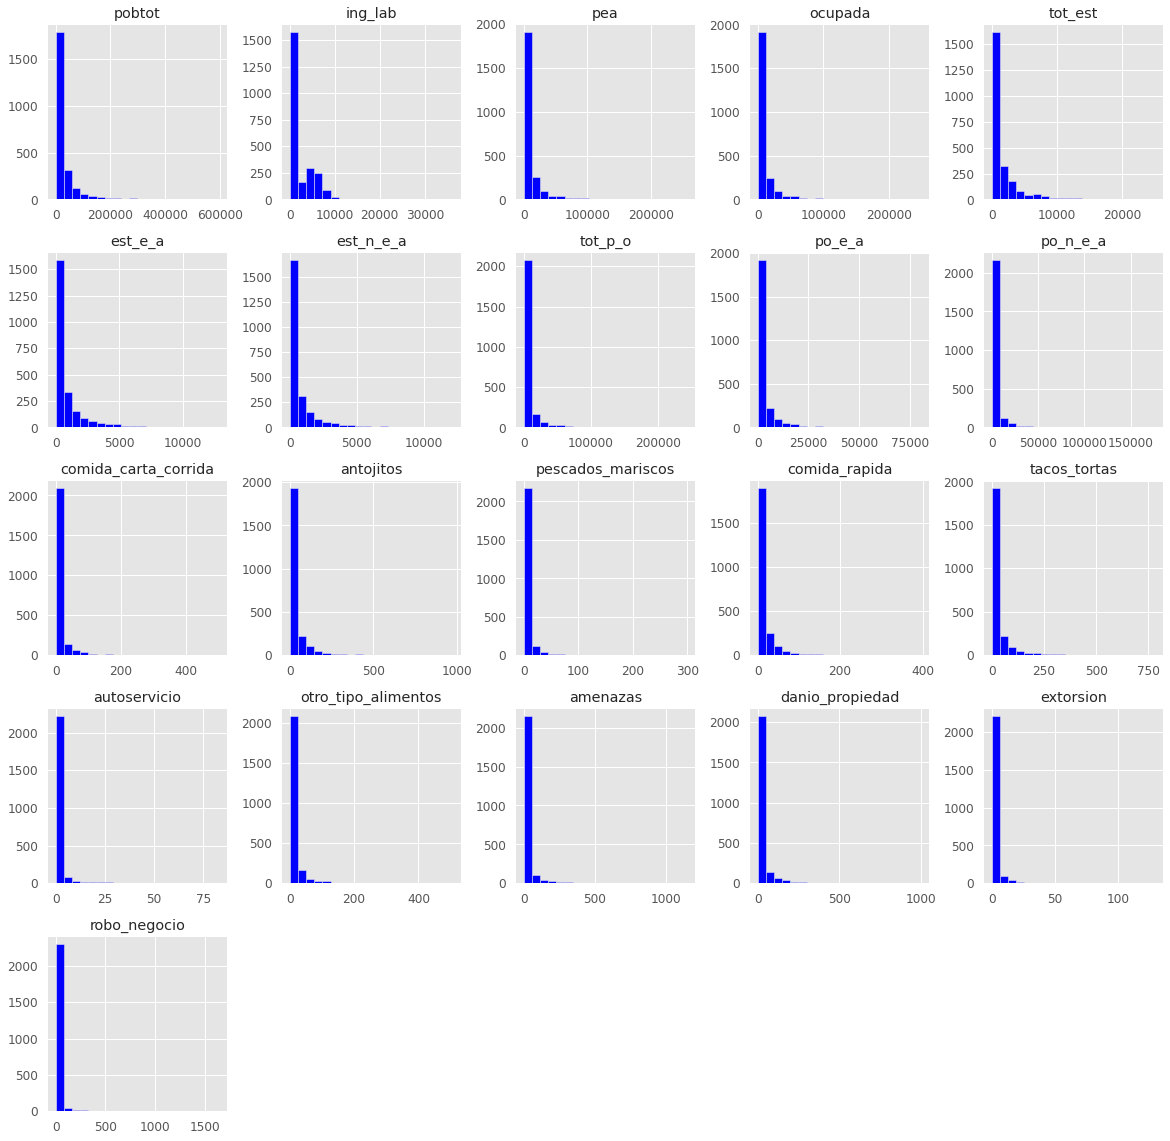

In [67]:
dataframe2 = df.copy()
dataframe2['Cluster'] = labels

aux = dataframe2.columns.tolist()
aux = aux[0:len(aux)-1]

# Grupo 0 

data_grupo0 = dataframe2[dataframe2['Cluster'] == 0]

data_grupo0[aux].hist(bins=20,color='blue');

In [71]:
round(data_grupo0[aux].describe(), 2)

,pobtot,ing_lab,pea,ocupada,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,amenazas,danio_propiedad,extorsion,robo_negocio
count,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00,2411.00
mean,31872.98,1898.75,11654.83,11171.80,1736.98,951.03,785.95,7651.02,3731.64,3919.37,14.75,37.42,6.05,17.80,34.47,1.72,15.06,29.22,32.97,2.45,16.90
std,59585.36,2925.19,24658.73,23678.69,2997.57,1635.75,1387.83,18267.45,8319.48,10560.20,36.20,80.71,17.49,37.33,73.77,5.99,38.17,86.66,89.01,9.20,76.98
min,0.00,0.00,0.00,0.00,7.00,5.00,2.00,17.00,13.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4083.50,0.00,1160.00,1109.50,164.00,93.00,62.50,484.50,260.00,187.00,1.00,2.00,0.00,1.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00
50%,12747.00,0.00,3934.00,3766.00,584.00,330.00,247.00,1779.00,975.00,747.00,3.00,9.00,1.00,5.00,9.00,0.00,4.00,4.00,5.00,0.00,0.00
75%,31487.50,4127.20,10270.50,9809.50,1874.50,1023.50,838.00,5996.00,3161.00,2885.50,12.00,34.00,4.00,17.00,30.00,1.00,12.00,17.00,22.00,1.00,4.00
max,597207.00,36323.24,257693.00,248993.00,25097.00,12885.00,12212.00,243203.00,80543.00,176286.00,502.00,977.00,300.00,397.00,783.00,83.00,508.00,1153.00,1001.00,129.00,1648.00


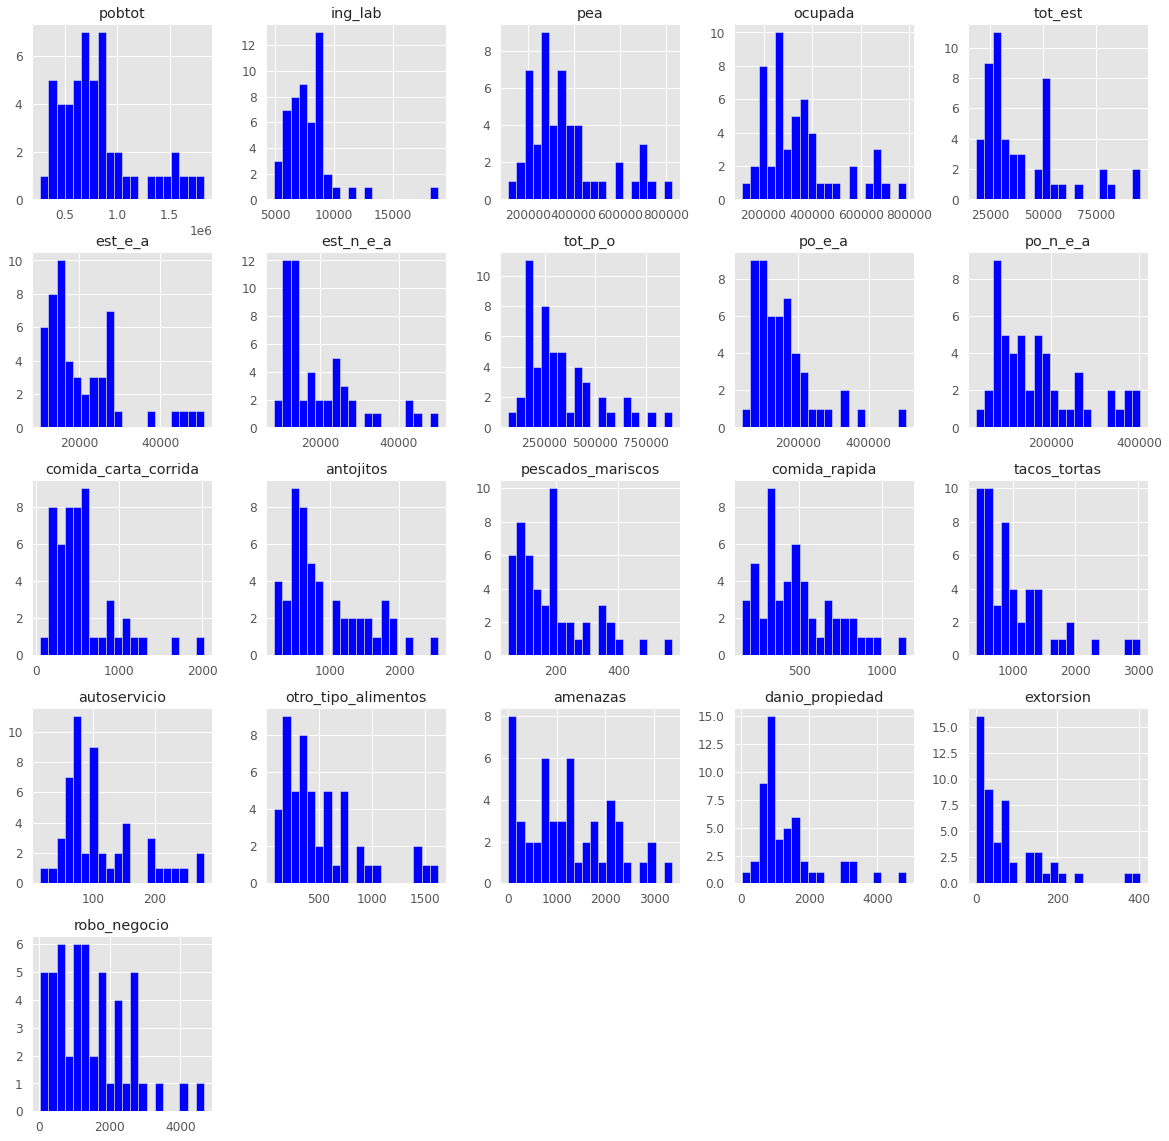

In [68]:
# Grupo 1

data_grupo1 = dataframe2[dataframe2['Cluster'] == 1]

data_grupo1[aux].hist(bins=20,color='blue');

In [72]:
round(data_grupo1[aux].describe(), 2)

,pobtot,ing_lab,pea,ocupada,tot_est,est_e_a,est_n_e_a,tot_p_o,po_e_a,po_n_e_a,comida_carta_corrida,antojitos,pescados_mariscos,comida_rapida,tacos_tortas,autoservicio,otro_tipo_alimentos,amenazas,danio_propiedad,extorsion,robo_negocio
count,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00,52.00
mean,820865.52,7897.15,363320.90,349042.44,40027.38,20926.67,19100.71,326864.02,157447.42,169416.62,573.62,929.29,188.88,485.17,1005.79,111.46,506.00,1193.69,1339.44,77.77,1459.12
std,377396.97,2203.73,165615.35,158768.52,19177.87,9860.48,9816.93,178963.12,87347.87,99159.19,373.56,555.46,114.10,228.32,574.86,63.31,372.30,890.24,956.03,89.01,1049.09
min,264251.00,4900.50,116220.00,112276.00,18496.00,10290.00,8206.00,70688.00,40485.00,30203.00,56.00,207.00,49.00,153.00,414.00,14.00,82.00,0.00,33.00,1.00,44.00
25%,563896.25,6639.31,255407.75,245782.75,26482.25,14106.25,12046.75,183863.50,93835.50,91056.75,339.00,534.75,98.75,316.00,629.00,68.00,240.75,490.50,771.75,18.75,542.75
50%,722180.00,7645.79,325746.00,312011.00,31587.50,17510.00,14496.50,272641.50,142747.00,143291.00,486.00,695.00,168.50,453.00,857.00,96.00,396.50,1065.50,966.00,50.50,1259.00
75%,895588.50,8583.60,406125.50,392853.50,50322.50,26174.00,23593.75,419400.75,182981.50,206032.25,624.75,1300.25,230.25,633.25,1256.50,139.50,669.25,1826.75,1571.25,107.00,2159.75
max,1827868.00,18849.13,825520.00,786218.00,95568.00,50880.00,50039.00,879056.00,505363.00,401413.00,2018.00,2552.00,570.00,1147.00,3030.00,280.00,1619.00,3366.00,4835.00,403.00,4664.00


In [69]:
mask = (df_pca.label == 1)
df_pca.loc[mask]

,C1,C2,C3,C4,C5,CVEGEO,imun,ent,nom_ent,mun,nom_mun,label,pobtot,ing_lab,pea,ocupada,tot_est
0,29.129027,-2.706719,-1.546377,-7.802444,-5.706800,1001,1001,1,Aguascalientes,1,Aguascalientes,1,877190,7676.46,382550,367528,46426
11,13.001855,-3.313471,0.493949,-1.335648,-1.911712,2001,2001,2,Baja California,1,Ensenada,1,486639,8626.94,210634,204081,23766
12,26.580546,-5.467672,-2.027470,-1.765270,-8.103461,2002,2002,2,Baja California,2,Mexicali,1,988417,8449.05,429396,411812,35876
14,40.706283,-8.956581,-4.277298,3.470504,-5.800479,2004,2004,2,Baja California,4,Tijuana,1,1641570,8569.15,741226,714819,58150
61,17.264048,-4.727640,0.073446,-2.514333,-1.599492,5030,5030,5,Coahuila de Zaragoza,30,Saltillo,1,807537,9474.68,339023,327417,29574
66,19.081300,-3.840646,-0.510080,-5.438979,-1.711017,5035,5035,5,Coahuila de Zaragoza,35,Torreón,1,679288,7199.74,284835,270281,28868
179,18.344623,1.363385,0.619218,-0.524836,6.112433,7101,7101,7,Chiapas,101,Tuxtla Gutiérrez,1,598710,6972.76,263449,253096,40519
221,22.723298,-5.827987,-0.723921,-0.401994,-1.466232,8019,8019,8,Chihuahua,19,Chihuahua,1,878062,8927.93,390819,377117,36291
239,34.493137,-11.403279,-3.500648,-5.622833,-10.443474,8037,8037,8,Chihuahua,37,Juárez,1,1391180,8009.33,597127,575889,39929
270,13.405203,-1.045849,-0.014363,1.655619,0.117043,9002,9002,9,Ciudad de México,2,Azcapotzalco,1,400161,8828.98,188982,180813,18496


In [ ]:
y = df_pca['label']
X = df_pca.drop(['label','imun','ent','mun'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
mun_geo = geopandas.read_file("https://github.com/Walt9819/factores-impacto-desempleo-mexico/blob/main/AD_Python/data/mun2019gw.zip?raw=true")

In [ ]:
mun_geo

,CVEGEO,CVE_ENT,CVE_MUN,NOM_ENT,AREA,PERIMETER,COV_,COV_ID,NOM_MUN,geometry
0,01001,01,001,Aguascalientes,116635.924760,256.631026,0,1,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0..."
1,01002,01,002,Aguascalientes,54337.426596,192.096428,1,2,Asientos,"POLYGON ((-102.05189 22.29144, -102.05121 22.2..."
2,01003,01,003,Aguascalientes,92335.783227,171.636168,2,3,Calvillo,"POLYGON ((-102.68569 22.09963, -102.69087 22.0..."
3,01004,01,004,Aguascalientes,12838.354453,73.352682,3,4,Cosío,"POLYGON ((-102.28787 22.41649, -102.28753 22.4..."
4,01005,01,005,Aguascalientes,49989.509147,163.500810,4,5,Jesús María,"POLYGON ((-102.33568 22.05067, -102.33348 22.0..."
...,...,...,...,...,...,...,...,...,...,...
2460,32054,32,054,Zacatecas,37142.598661,119.022381,2460,2461,Villa Hidalgo,"POLYGON ((-101.69490 22.51777, -101.69472 22.5..."
2461,32055,32,055,Zacatecas,215650.560215,351.736263,2461,2462,Villanueva,"POLYGON ((-102.78252 22.67373, -102.78221 22.6..."
2462,32056,32,056,Zacatecas,43682.101046,139.065402,2462,2463,Zacatecas,"POLYGON ((-102.76690 22.84147, -102.76619 22.8..."
2463,32057,32,057,Zacatecas,21844.700671,66.167468,2463,2464,Trancoso,"POLYGON ((-102.22547 22.80920, -102.22946 22.7..."


In [ ]:
df_pca['CVEGEO'] = df_pca['CVEGEO'].astype(str)
df_pca['CVEGEO'] = df_pca['CVEGEO'].str.zfill(5)

In [ ]:
df_pca

,C1,C2,C3,C4,C5,CVEGEO,imun,ent,nom_ent,mun,nom_mun,label,pobtot,ing_lab,pea,ocupada,tot_est
0,29.129027,-2.706719,-1.546377,-7.802444,-5.706801,01001,1001,1,Aguascalientes,1.0,Aguascalientes,1,877190.0,7676.46,382550.0,367528.0,46426
1,-0.387030,-0.383548,1.231530,-0.152269,-0.421775,01002,1002,1,Aguascalientes,2.0,Asientos,0,46464.0,5863.52,13914.0,13108.0,989
2,0.254651,-0.242492,1.200353,-0.207465,-0.251577,01003,1003,1,Aguascalientes,3.0,Calvillo,0,56048.0,5784.97,20099.0,19352.0,3280
3,-0.738144,-0.190597,1.375053,0.193453,-0.244863,01004,1004,1,Aguascalientes,4.0,Cosío,0,15577.0,6096.05,4869.0,4627.0,1000
4,2.636880,-0.741091,0.990886,-0.463559,-0.842080,01005,1005,1,Aguascalientes,5.0,Jesús María,0,120405.0,6262.18,51020.0,49795.0,6377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,-1.054278,0.041267,0.064727,0.060375,-0.122994,32054,32054,32,Zacatecas,54.0,Villa Hidalgo,0,19155.0,1877.31,4538.0,4324.0,423
2459,-0.306748,0.271599,-0.547486,-0.151588,0.059271,32055,32055,32,Zacatecas,55.0,Villanueva,0,30240.0,0.00,9018.0,8176.0,3532
2460,5.191246,1.544511,1.533360,1.451685,-2.139547,32056,32056,32,Zacatecas,56.0,Zacatecas,0,146147.0,7421.03,60889.0,58330.0,9716
2461,-0.704920,0.006129,1.558814,0.264889,-0.420455,32057,32057,32,Zacatecas,57.0,Trancoso,0,19413.0,6537.04,6039.0,5703.0,665


In [ ]:
mun_pca_merge = pd.merge(mun_geo, df_pca, left_on = ['CVEGEO'], right_on = ['CVEGEO'], how = 'left')

In [ ]:
mun_pca_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2465 entries, 0 to 2464
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CVEGEO     2465 non-null   object  
 1   CVE_ENT    2465 non-null   object  
 2   CVE_MUN    2465 non-null   object  
 3   NOM_ENT    2465 non-null   object  
 4   AREA       2465 non-null   float64 
 5   PERIMETER  2465 non-null   float64 
 6   COV_       2465 non-null   int64   
 7   COV_ID     2465 non-null   int64   
 8   NOM_MUN    2465 non-null   object  
 9   geometry   2465 non-null   geometry
 10  C1         2463 non-null   float64 
 11  C2         2463 non-null   float64 
 12  C3         2463 non-null   float64 
 13  C4         2463 non-null   float64 
 14  C5         2463 non-null   float64 
 15  imun       2463 non-null   float64 
 16  ent        2463 non-null   float64 
 17  nom_ent    2463 non-null   object  
 18  mun        2463 non-null   float64 
 19  nom_mun    2463 non

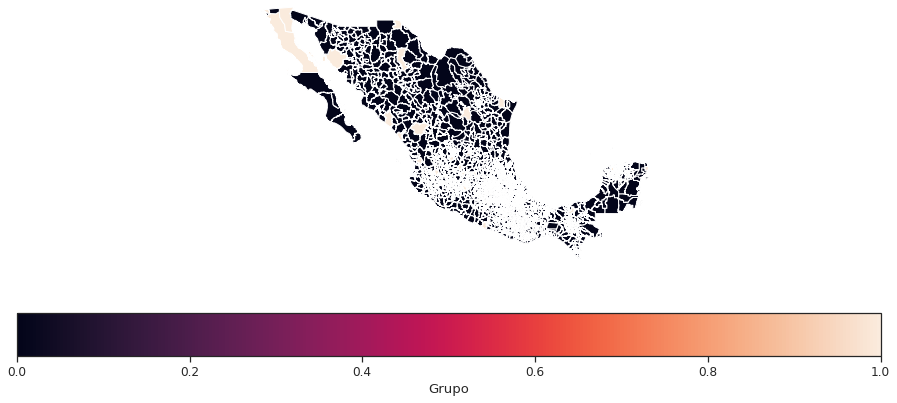

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

mun_pca_merge.plot(ax=ax, column='label', legend=True, legend_kwds={'label': "Grupo", 
                                                                    'orientation': "horizontal"})
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

In [ ]:
# Grupo 0 Morado, Grupo 1 Verde, Grupo 2 Amarillo
mun_pca_merge.plot_bokeh(
    figsize=(900, 600),
    simplify_shapes=500,
    category="label",
    show_colorbar=False,
    colormap=['#440154', '#79D151', '#FDE724'],
    hovertool_columns=["nom_ent",'nom_mun', "label"],
    tile_provider="STAMEN_TERRAIN_RETINA")

Figure(id='1002', ...)

## Validación del modelo de datos

Para validar nuestro modelo dividimos el conjunto de datos resultantes del K-Means en un set de entrenamiento y otro pruebas, y aplicamos un modelo de regresión logística y otra de random forest para hacer las predicciones.  La matriz de confusión  muestra cuántos resultados equivocados tuvo cada clase. La valoración que nos conviene analizar es la de F1-score que toma en cuenta la precisión y recall. El promedio de F1 para ambos modelos fluctua entre 96% - 99%.

In [ ]:
y = df_pca['label']
X = df_pca.drop(['label','imun', 'ent', 'nom_ent','mun','nom_mun','CVEGEO'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

In [ ]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



### Regresión logística

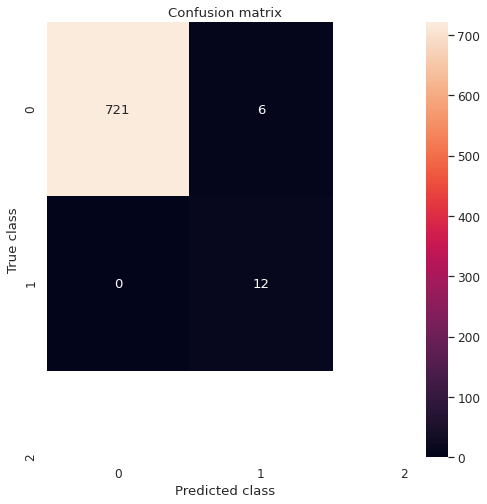

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       727
           1       0.67      1.00      0.80        12

    accuracy                           0.99       739
   macro avg       0.83      1.00      0.90       739
weighted avg       0.99      0.99      0.99       739



In [ ]:
LABELS = [0,1,2]
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=50, verbose=2,
                       warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


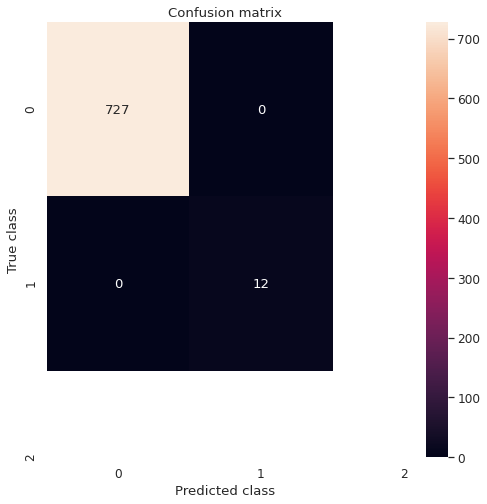

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       1.00      1.00      1.00        12

    accuracy                           1.00       739
   macro avg       1.00      1.00      1.00       739
weighted avg       1.00      1.00      1.00       739



In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)